In [102]:
from openai import OpenAI
client = OpenAI()

def get_model_response(prompt, model="gpt-4", max_tokens=50):
    completion = client.chat.completions.create(
        model=model,
        logprobs = True,
        messages=[
            {"role": "developer", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    print(completion)
    response_message = completion.choices[0].message.content
    print(response_message)
    return response_message

In [103]:
def compute_confidence(answer):
    logprobs = answer["logprobs"]["token_logprobs"]
    confidence = sum(logprobs)  # Sum of log-probabilities
    print(f"Answer {answer} Confidence: {sum(logprobs)}")
    return confidence

In [104]:
def selective_qa(prompt, threshold=0.5):
    response = get_model_response(prompt)
    confidence = compute_confidence(response)
    
    if confidence < threshold:
        return "[No Answer]"
    return response["text"].strip()

In [105]:
def evaluate_utility(response, ground_truth, risk_penalty=-1):
    if response == "[No Answer]":
        return 0  # No reward or penalty
    elif response == ground_truth:
        return 1  # Correct answer reward
    else:
        return risk_penalty  # Incorrect answer penalty

In [106]:
import numpy as np
import matplotlib.pyplot as plt

def plot_utility_vs_threshold(thresholds, responses, ground_truths, risk_penalty=-1):
    utilities = [np.mean([evaluate_utility(resp, gt, risk_penalty) for resp, gt in zip(responses, ground_truths)])
                 for t in thresholds]
    
    plt.plot(thresholds, utilities, marker='o', linestyle='-')
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Average Utility")
    plt.title("Impact of Confidence Threshold on Utility")
    plt.show()

In [107]:
sample_dataset = [
    {"question": "What is 12 + 25?", "answer": "37"},
    {"question": "What is the capital of France?", "answer": "Paris"},
    {"question": "Solve for x: 2x + 3 = 9", "answer": "x = 3"},
    {"question": "What is the square root of 144?", "answer": "12"},
    {"question": "Who wrote '1984'?", "answer": "George Orwell"},
    {"question": "What is the derivative of x^2?", "answer": "2x"},
    {"question": "What is full of holes but still holds water?", "answer": "sponge"},
    {"question": "What can you break, even if you never pick it up or touch it?", "answer": "a promise"},
    {"question": "What is always in front of you but can’t be seen?", "answer": "the future"},
    {"question": "What can run but never walks, has a mouth but never talks, has a head but never weeps, has a bed but never sleeps?", "answer": "river"},
    {"question": "The more you take, the more you leave behind. What are they?", "answer": "footprints"},
    {"question": "With pointed fangs, I sit and wait; with piercing force I crunch out fate; grabbing victims, proclaiming might; physically joining with a single bite. What am I?", "answer": "stapler"},
]


In [108]:
def generate_responses(dataset, compute_budgets):
    results = []
    for compute_budget in compute_budgets:
        print(f"Testing with compute budget: {compute_budget} tokens...")
        for item in dataset:
            response = get_model_response(item["question"], max_tokens=compute_budget)
            results.append({
                "question": item["question"],
                "ground_truth": item["answer"],
                "response": response.strip(),
                "compute_budget": compute_budget
            })
    return results


In [109]:
compute_budgets = [10, 30, 50, 100]
responses = generate_responses(sample_dataset, compute_budgets)


Testing with compute budget: 10 tokens...
ChatCompletion(id='chatcmpl-B482zpWUanXmxCJxZLKNMPNBvlM5I', choices=[Choice(finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='12', bytes=[49, 50], logprob=-0.02815967, top_logprobs=[]), ChatCompletionTokenLogprob(token=' +', bytes=[32, 43], logprob=-9.610702e-06, top_logprobs=[]), ChatCompletionTokenLogprob(token=' ', bytes=[32], logprob=-3.190179e-05, top_logprobs=[]), ChatCompletionTokenLogprob(token='25', bytes=[50, 53], logprob=0.0, top_logprobs=[]), ChatCompletionTokenLogprob(token=' equals', bytes=[32, 101, 113, 117, 97, 108, 115], logprob=-0.015039189, top_logprobs=[]), ChatCompletionTokenLogprob(token=' ', bytes=[32], logprob=-0.010042212, top_logprobs=[]), ChatCompletionTokenLogprob(token='37', bytes=[51, 55], logprob=-7.89631e-07, top_logprobs=[]), ChatCompletionTokenLogprob(token='.', bytes=[46], logprob=-0.0012392756, top_logprobs=[])], refusal=None), message=ChatCompletionMessage(cont

In [110]:
print("Responses:") # Print the responses
for item in responses:
    print(f"Compute Budget: {item['compute_budget']}")
    print(f"Q: {item['question']} | A: {item['ground_truth']} | R: {item['response']}")

Responses:
Compute Budget: 10
Q: What is 12 + 25? | A: 37 | R: 12 + 25 equals 37.
Compute Budget: 10
Q: What is the capital of France? | A: Paris | R: The capital of France is Paris.
Compute Budget: 10
Q: Solve for x: 2x + 3 = 9 | A: x = 3 | R: To solve for x, you would first subtract 3 from both sides of the equation:

2x + 3 - 3 = 9 - 3
2x = 6

Then, you divide each side by 2:

2x/2 = 6/2
x = 3
Compute Budget: 10
Q: What is the square root of 144? | A: 12 | R: The square root of 144 is 12.
Compute Budget: 10
Q: Who wrote '1984'? | A: George Orwell | R: '1984' was written by George Orwell.
Compute Budget: 10
Q: What is the derivative of x^2? | A: 2x | R: The derivative of x^2 is 2x.
Compute Budget: 10
Q: What is full of holes but still holds water? | A: sponge | R: A sponge is full of holes but still holds water.
Compute Budget: 10
Q: What can you break, even if you never pick it up or touch it? | A: a promise | R: You can break a promise without ever picking it up or touching it.
Com

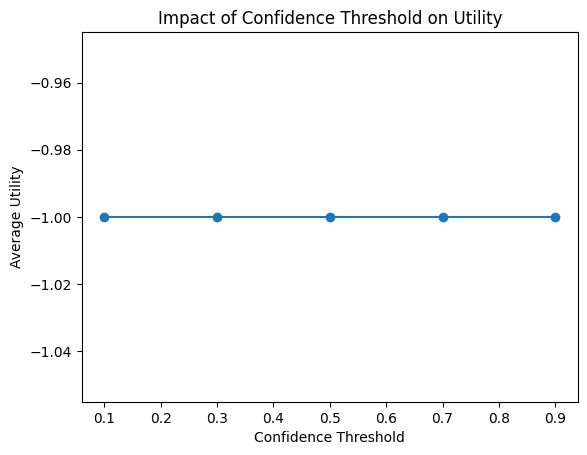

In [111]:
import numpy as np
import matplotlib.pyplot as plt

def plot_utility_vs_threshold(thresholds, responses, ground_truths, risk_penalty=-1):
    utilities = [np.mean([evaluate_utility(resp, gt, risk_penalty) for resp, gt in zip(responses, ground_truths)])
                 for t in thresholds]
    
    plt.plot(thresholds, utilities, marker='o', linestyle='-')
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Average Utility")
    plt.title("Impact of Confidence Threshold on Utility")
    plt.show()

plot_utility_vs_threshold([0.1, 0.3, 0.5, 0.7, 0.9], responses, sample_dataset)